In [1]:
import sys
sys.path.append('/NDDepth/Estimation/nddepth_custom')

In [2]:

import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
from networks.NewCRFDepth import NewCRFDepth
from utils import post_process_depth, flip_lr, compute_errors
import open3d as o3d

IMG_PATH = "/scratchdata/nyu_depth_v2/official_splits/test/kitchen/rgb_00201.jpg"
DEPTH_PATH = "/scratchdata/nyu_depth_v2/official_splits/test/kitchen/sync_depth_00201.png"
MODEL_PATH = "/scratchdata/test.pth"

ENCODER = "large07"
MAX_DEPTH = 10
EPOCH = 5

torch.manual_seed(42)

model = NewCRFDepth(version=ENCODER, inv_depth=False, max_depth=MAX_DEPTH, pretrained=None).to("cuda")
model.train()
num_params = sum([np.prod(p.size()) for p in model.parameters()])
print("== Total number of parameters: {}".format(num_params))

num_params_update = sum([np.prod(p.shape) for p in model.parameters() if p.requires_grad])
print("== Total number of learning parameters: {}".format(num_params_update))

model = torch.nn.DataParallel(model)
model.cuda()

checkpoint = torch.load(MODEL_PATH, map_location='cpu')
model.load_state_dict(checkpoint['model'])
print("== Loaded checkpoint '{}'".format(MODEL_PATH))
del checkpoint

print("== Model Initialized")
cudnn.benchmark = True


/usr/local/lib/python3.10/dist-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


== Load encoder backbone from: None
== Total number of parameters: 348400139
== Total number of learning parameters: 348400139


NameError: name 'args' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3410363].


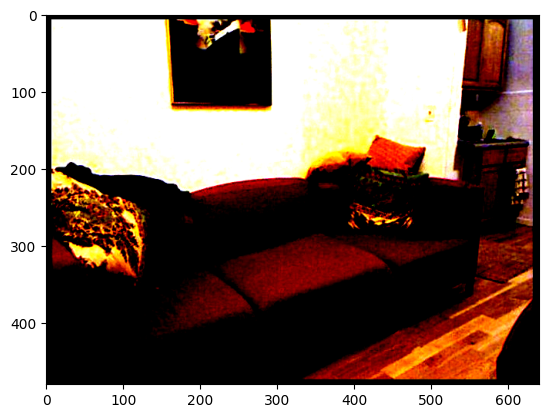

In [ ]:
image = np.asarray(Image.open(IMG_PATH), dtype=np.float32) / 255.0

image = torch.from_numpy(image.transpose((2, 0, 1)))
image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)


plt.imshow(image.permute(1, 2, 0))

In [ ]:
K = np.array([[518.8579 / 4.0, 0, 325.5824 / 4.0, 0],
            [0, 518.8579 / 4.0, 253.7362 / 4.0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]], dtype=np.float32) 
inv_K = np.linalg.pinv(K)
inv_K = torch.from_numpy(inv_K)

In [ ]:
model.eval()
with torch.no_grad():
    image_torch = torch.Tensor(image.unsqueeze(0).cuda())
    inv_K_torch = torch.Tensor(inv_K.unsqueeze(0).cuda())

    depth1_list, uncer1_list, depth2_list, uncer2_list, normals, distances = model(image_torch, inv_K_torch, EPOCH)
    
    pred_depth = 0.5 * (depth1_list[-1] + depth2_list[-1])
    
    image_flipped = flip_lr(image_torch)
    depth1_list_flipped, uncer1_list_flipped, depth2_list_flipped, uncer2_list_flipped, normals_flipped, distances_flipped = model(image_flipped, inv_K_torch, EPOCH)
    pred_depth_flipped = 0.5 * (depth1_list_flipped[-1] + depth2_list_flipped[-1])
    pred_depth = post_process_depth(pred_depth, pred_depth_flipped)
    normals = (0.5 * (normals + 1)).permute(0, 2, 3, 1)

    pred_depth = pred_depth.cpu().numpy().squeeze()
    pred_normal = normals.cpu().numpy().squeeze()

In [ ]:
print(pred_depth)

[[3.4623504 3.4623504 3.3879485 ... 3.647278  3.616174  3.616174 ]
 [3.4623504 3.4623504 3.3879485 ... 3.647278  3.616174  3.616174 ]
 [3.6199398 3.6199398 3.587903  ... 3.7419066 3.699753  3.699753 ]
 ...
 [4.6077943 4.6077943 4.827164  ... 4.9207716 4.7106085 4.7106085]
 [4.734889  4.734889  4.96532   ... 5.056012  4.835171  4.835171 ]
 [4.734889  4.734889  4.96532   ... 5.056012  4.835171  4.835171 ]]


2.6505005 8.635462


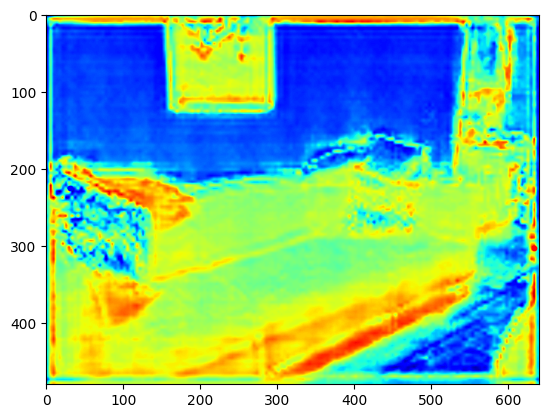

In [ ]:
pred_depth = np.reshape(pred_depth, (480, 640))
print(pred_depth.min(), pred_depth.max())
#pred_depth = pred_depth / pred_depth.max()
#Find index of max pred_depth
max_index = np.where(pred_depth == pred_depth.max())
min_index = np.where(pred_depth == pred_depth.min())

plt.imshow(pred_depth, cmap='jet')
plt.scatter(max_index[1], max_index[0], c='r', s=10)
plt.scatter(min_index[1], min_index[0], c='b', s=10)

0.0 4.475


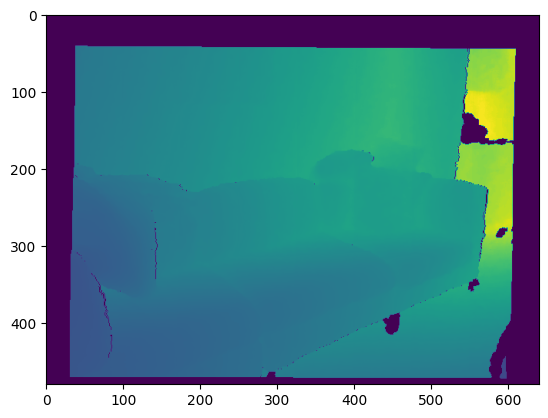

In [ ]:
depth = Image.open(DEPTH_PATH)
depth = np.reshape(depth, (480,640))/1000
print(depth.min(), depth.max())
plt.imshow(depth)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[np.float64(23.360388613632516), np.float64(1.3680014182871283), np.float64(0.36324857010661554), np.float64(2.9172951656658768), np.float64(4.1685012723289185), np.float64(0.8678089185646515), np.float64(0.020029367325658104), np.float64(0.06358238811687345), np.float64(0.18274988827647848)]


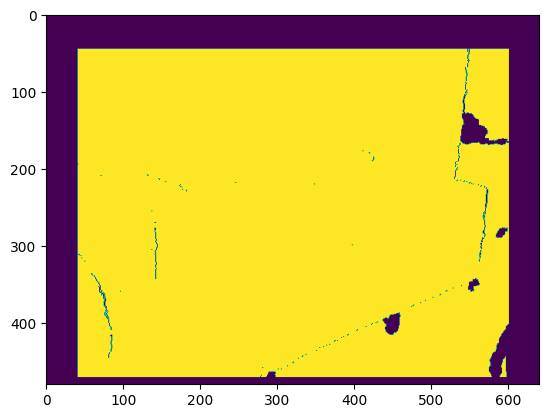

In [ ]:
valid_mask = np.logical_and(depth > 1e-3, depth < 10)
eval_mask = np.zeros(valid_mask.shape)
eval_mask[45:471, 41:601] = 1
valid_mask = np.logical_and(valid_mask, eval_mask)
print(valid_mask)
print(compute_errors(depth[valid_mask],pred_depth[valid_mask]))
plt.imshow(valid_mask)

In [ ]:
def depth_to_pcd(depth_image, intrinsic, ):
    # Get dimensions of the depth image
    height, width = depth_image.shape

    # Generate a grid of (x, y) coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Flatten the arrays
    x = x.flatten()
    y = y.flatten()
    depth = depth_image.flatten()

    # Calculate 3D coordinates
    fx, fy, cx, cy = intrinsic[0], intrinsic[5], intrinsic[2], intrinsic[6]
    z = depth

    x_3d = (x - cx) * z / fx
    y_3d = (y - cy) * z / fy

    # Create a point cloud
    points = np.vstack((x_3d, y_3d, z)).T
    return points

In [ ]:
camera_K = K[:3,:3].flatten() * 4
coord = depth_to_pcd(pred_depth,camera_K)
color = Image.open(IMG_PATH)
color = color.resize((640, 480), Image.BILINEAR)
color = np.array(color, dtype=np.float64)
color = color.reshape(-1, 3)/255.0

coord = coord[valid_mask.flatten()]
color = color[valid_mask.flatten()]

color = np.delete(color, np.where(coord[:, 2] == 0), axis=0)
coord = np.delete(coord, np.where(coord[:, 2] == 0), axis=0)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(coord)
pcd.colors = o3d.utility.Vector3dVector(color)
o3d.visualization.draw_geometries([pcd])